# Model Initiation

In [132]:
#Libary
import pandas as pd
import os
import numpy as np

In [ ]:
#tes

In [133]:
import ixmp

mp = ixmp.Platform()

In [134]:
#convert mtoe to GWa
conv_mtoe_gwa = 11.63*1000/8760
conv_twh_gwa = 1000/8760

In [135]:
import message_ix

scenario = message_ix.Scenario(
    mp, model='Indonesia Prototype', scenario='baseline', version='new'
)

# Functions

In [136]:
def get_act_vtg_years(y_df,horizon,lifetimes,technology):
    """
    get active years and vintage years according to technology lifetime
    """
    for year in horizon:
        count = y_df[y_df['year_vtg'] == year]['year_vtg'].value_counts()
        count = count[year]
        if count > lifetimes[f'{technology}']:
            df = y_df[y_df['year_vtg'] == year]
            value = (count - lifetimes[f'{technology}'])*-1
            index_to_remove = df.index[value:]

            y_df = y_df.drop(index=index_to_remove)

    return y_df['year_vtg'],y_df['year_act']
            


In [137]:
def fix_negative_values(df, fuel_col='fuel', year_col='Year', value_col='value'):
    """
    Fix negative values by transferring values within the same fuel type.
    Priority: Add to next year if exists, otherwise pull from previous years.
    
    Parameters:
    - df: pandas DataFrame
    - fuel_col: column name for fuel types
    - year_col: column name for years
    - value_col: column name for values to adjust

    Returns:
    - Adjusted DataFrame
    """
    # Sort first to ensure correct order
    df = df.sort_values(by=[fuel_col, year_col]).reset_index(drop=True)
    
    # Iterate through DataFrame
    i = 0
    while i < len(df):
        if df.loc[i, value_col] < 0:
            current_fuel = df.loc[i, fuel_col]
            
            # Try to find next year with same fuel
            next_indices = df.index[(df.index > i) & (df[fuel_col] == current_fuel)]
            
            if len(next_indices) > 0:
                next_i = next_indices[0]
                df.loc[next_i, value_col] += df.loc[i, value_col]
                df.loc[i, value_col] = 0
            else:
                # No next year: pull from previous years
                prev_indices = df.index[(df.index < i) & (df[fuel_col] == current_fuel)].tolist()
                prev_indices = prev_indices[::-1]  # Closest previous first

                for prev_i in prev_indices:
                    df.loc[i, value_col] += df.loc[prev_i, value_col]
                    df.loc[prev_i, value_col] = 0
                    if df.loc[i, value_col] >= 0:
                        break
        i += 1
    
    return df


In [138]:
def fill_missing_values(main_df, reference_df, fuel_col='fuel', year_col='Year', value_col='value', year=2005):
    """
    Fill missing or zero values in main_df using reference_df.

    Parameters:
    - main_df: DataFrame that needs filling
    - reference_df: DataFrame providing reference values
    - fuel_col: column name for fuel types
    - year_col: column name for years
    - value_col: column name for values to adjust

    Returns:
    - Filled DataFrame
    """
    df = main_df.copy()
    
    for idx, row in df.iterrows():
        # If value is NaN or zero
        if pd.isna(row[value_col]):
            ref_value = reference_df.loc[
                (reference_df[fuel_col] == row[fuel_col]) & (reference_df[year_col] == year),
                value_col
            ]
            if not ref_value.empty:
                df.at[idx, value_col] = ref_value.values[0]
    
    return df

# Model Structure

<img src='Messageix Indonesia Structure.drawio.png' width='1000'>

In [139]:
historical_horizon = list(range(2005,2021,5))
model_horizon = list(range(2025,2071,5))

horizon = historical_horizon+model_horizon

scenario.add_horizon(year=historical_horizon+model_horizon)


In [140]:
country='IDN'
scenario.add_spatial_sets({'country':country})

In [141]:
demand_com = [
    'industry_el',
    'transport_el',
    'commercial_el',
    'residential_el'
]

commodities = [
    'coal',
    'electricity',
    'gas',
    'oil'
]

all_com = demand_com + commodities

In [142]:

ppl_tec = [
    'coal_ppl',
    'gas_ppl',
    'oil_ppl',
    'hydro_ppl',
    'solar_ppl',
    'wind_ppl',
    'geo_ppl',
    'bio_ppl',
    'nuclear_ppl'
]

t_d_tec = [
    'electricity_grid'
           ]

demand_tec = [
    'industry_el_tec',
    'transport_el_tec',
    'commercial_el_tec',
    'residential_el_tec'
]

all_tec =  ppl_tec + t_d_tec + demand_tec

In [143]:
scenario.add_set('commodity',all_com)
scenario.add_set('level',['primary','secondary','final','useful'])
scenario.add_set('technology',all_tec)
scenario.add_set('mode','standard')
scenario.add_set('level_resource','primary')
scenario.add_set('grade',['a_coal','a_gas','a_oil'])

## Demand Parameter

In [144]:
path = os.getcwd()
path = os.path.dirname(path)
filename = 'COPY Indonesia AEO8 Data.xlsx'
filename = os.path.join(path,filename)

sectors = ['Industry','Transport','Commercial','Residential']
sector_models = ['industry_el','transport_el','commercial_el','residential_el']

In [145]:
sectors

['Industry', 'Transport', 'Commercial', 'Residential']

In [146]:
for sector,sector_model in zip(sectors,sector_models):

    df = pd.read_excel(filename,sheet_name=f'IDN_{sector}_BAS',skiprows=6)
    index = df[df['Fuel'] == 'Total'].index[0] #get index of the targeted sliced rows
    df = df.loc[:index-1]
    df = df.melt(id_vars='Fuel', value_vars=list(range(2005,2051,5)),var_name='Year')
    df = df[(df['Fuel'] == 'Electricity') & (df['Year']>2020)]
    df.value = df.value*conv_mtoe_gwa
    coeffs = np.polyfit(df["Year"].values.astype(int), df["value"].values.astype(float), deg=1)
    poly = np.poly1d(coeffs)

    # Predict values for the missing years
    future_years = list(range(2055,2071,5))
    predicted_values = poly(future_years)
    newrow = pd.DataFrame({'Year':list(range(2055,2071,5)),'Fuel':['Electricity' for _ in range(4)], 'value':predicted_values})
    df = pd.concat([df,newrow])
    values = df.value.tolist()



    df_demand = pd.DataFrame(
        {
            'node':country,
            'commodity':f'{sector_model}',
            'level':'useful',
            'year': model_horizon,
            'time':'year',
            'value':values,
            'unit':'GWa'
        }
    )

    scenario.add_par('demand',df_demand)
    

## Engineering Parameters

In [147]:
year_df = scenario.vintage_and_active_years()
vintage_years,act_years = year_df["year_vtg"],year_df["year_act"]

In [148]:
#Technical Lifetime (data from LEAP)
from message_ix import make_df

base_technical_lifetime = {
    'node_loc': country,
    'year_vtg':vintage_years,
    'unit':'y'
}

lifetimes ={
    'coal_ppl':40,
    'gas_ppl':30,
    'oil_ppl':40,
    'hydro_ppl':40,
    'solar_ppl':20,
    'wind_ppl':20,
    'geo_ppl':30,
    'bio_ppl':30,
    'nuclear_ppl':60
}

for tec, val in lifetimes.items():
    df = make_df(base_technical_lifetime,technology=tec,value=val)
    scenario.add_par('technical_lifetime',df)



In [149]:
#Coal Input

vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'coal_ppl')
base_coal_input = {
    "node_loc":country,
    "year_vtg":vintage_years,
    "year_act":act_years,
    "mode":"standard",
    "node_origin":country,
    "commodity":"coal",
    "time":"year",
    "time_origin":"year"
}

coal_ppl = pd.DataFrame(
    dict(
        technology='coal_ppl',
        level='primary',
        value=1,
        unit='-',
        **base_coal_input,
    )
)

#Gas Input

vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'gas_ppl')
base_gas_input = {
    "node_loc":country,
    "year_vtg":vintage_years,
    "year_act":act_years,
    "mode":"standard",
    "node_origin":country,
    "commodity":"gas",
    "time":"year",
    "time_origin":"year"
}

gas_ppl = pd.DataFrame(
    dict(
        technology='gas_ppl',
        level='primary',
        value=1,
        unit='-',
        **base_gas_input,
    )
)

#Oil Input

vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'oil_ppl')
base_oil_input = {
    "node_loc":country,
    "year_vtg":vintage_years,
    "year_act":act_years,
    "mode":"standard",
    "node_origin":country,
    "commodity":"oil",
    "time":"year",
    "time_origin":"year"
}

oil_ppl = pd.DataFrame(
    dict(
        technology='oil_ppl',
        level='primary',
        value=1,
        unit='-',
        **base_oil_input,
    )
)

#Biomass Input
'''base_bio_input = {
    "node_loc":country,
    "year_vtg":vintage_years,
    "year_act":act_years,
    "mode":"standard",
    "node_origin":country,
    "commodity":"biomass",
    "time":"year",
    "time_origin":"year"
}

bio_ppl = pd.DataFrame(
    dict(
        technology='bio_ppl',
        level='primary',
        value=1,
        unit='-',
        **base_bio_input,
    )
)

#Nuclear Input
base_nuclear_input = {
    "node_loc":country,
    "year_vtg":vintage_years,
    "year_act":act_years,
    "mode":"standard",
    "node_origin":country,
    "commodity":"nuclear",
    "time":"year",
    "time_origin":"year"
}

nuclear_ppl = pd.DataFrame(
    dict(
        technology='nuclear_ppl',
        level='primary',
        value=1,
        unit='-',
        **base_nuclear_input,
    )
)'''


scenario.add_par("input",coal_ppl)
scenario.add_par("input",gas_ppl)
scenario.add_par("input",oil_ppl)
'''scenario.add_par("input",bio_ppl)
scenario.add_par("input",nuclear_ppl)'''

'scenario.add_par("input",bio_ppl)\nscenario.add_par("input",nuclear_ppl)'

In [150]:

#Electricity Input
vintage_years,act_years = pd.Series(horizon),pd.Series(horizon)
base_electr_input = {
    "node_loc":country,
    "year_vtg":vintage_years,
    "year_act":act_years,
    "mode":"standard",
    "node_origin":country,
    "commodity":"electricity",
    "time":"year",
    "time_origin":"year"
}

electr_grid = make_df(
    base_electr_input,
    technology='electricity_grid',
    level='secondary',
    value=1,
    unit='-',
)

scenario.add_par("input",electr_grid)

for tec in demand_tec:
    electr_in = make_df(
        base_electr_input,
        technology = f'{tec}',
        level = 'final',
        value=1,
        unit ='-'
    )
    scenario.add_par('input',electr_in)
    



In [151]:
#Data from LEAP
coal_ppl_eff = 0.37 
gas_ppl_eff = 0.33 
oil_ppl_eff = 0.45 
bio_ppl_eff = 0.62
nuclear_ppl_eff = 0.4
electr_grid_eff = 1


#Output
base_output = {
'node_loc':country,
'mode':'standard',
'node_dest':country,
'time':'year',
'time_dest':'year',   
}



#coal_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'coal_ppl')
coal_ppl = make_df(
    base_output,
    technology ='coal_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = coal_ppl_eff, 
    unit = '-'
    
)

#gas_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'gas_ppl')
gas_ppl = make_df(
    base_output,
    technology ='gas_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = gas_ppl_eff, 
    unit = '-'  
)

#oil_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'oil_ppl')
oil_ppl = make_df(
    base_output,
    technology ='oil_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = oil_ppl_eff, 
    unit = '-'  
)

#hydro_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'hydro_ppl')
hydro_ppl = make_df(
    base_output,
    technology ='hydro_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'  
)

#solar_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'solar_ppl')
solar_ppl = make_df(
    base_output,
    technology ='solar_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'  
)

#wind_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'wind_ppl')
wind_ppl = make_df(
    base_output,
    technology ='wind_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'  
)

#geo_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'geo_ppl')
geo_ppl = make_df(
    base_output,
    technology ='geo_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'  
)

#bio_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'bio_ppl')
bio_ppl = make_df(
    base_output,
    technology ='bio_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'  
)

#nuclear_ppl
vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,'nuclear_ppl')
nuclear_ppl = make_df(
    base_output,
    technology ='nuclear_ppl',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'secondary',
    value = 1, 
    unit = '-'  
)


#electricity grid
vintage_years,act_years = pd.Series(horizon),pd.Series(horizon)
electr_grid = make_df(
    base_output,
    technology ='electricity_grid',
    year_vtg = vintage_years,
    year_act = act_years,
    commodity ='electricity',
    level = 'final',
    value = electr_grid_eff, 
    unit = '-'
)

for tec in ppl_tec:
    df = globals()[f'{tec}']
    scenario.add_par('output',df)
    
scenario.add_par("output",electr_grid)

for tec,com in zip(demand_tec,demand_com):
    electr_out = make_df(
        base_output,
        technology = f'{tec}',
        commodity = f'{com}',
        year_vtg = vintage_years,
        year_act = act_years,
        level = 'useful',
        value=1,
        unit ='-'
    )
    scenario.add_par('output',electr_out)

In [152]:
#Capacity Factor (data from LEAP Max Availability)

base_capacity_factor = {
    'node_loc': country,
    'time':'year',
    'unit':'-'
}

capacity_factor ={
    'coal_ppl':0.8,
    'gas_ppl':0.85,
    'oil_ppl':0.95,
    'hydro_ppl':0.5177,
    'solar_ppl':0.1861,
    'wind_ppl':0.2634,
    'geo_ppl':0.8,
    'bio_ppl':0.8,
    'nuclear_ppl':0.95
}

for tec, val in capacity_factor.items():
    vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,tec)
    df = make_df(
        base_capacity_factor,
        technology=tec,
        year_vtg = vintage_years,
        year_act = act_years,
        value=val)
    scenario.add_par('capacity_factor',df)



## Technoeconomic Parameters

In [153]:
#Resource parameters

coal_potentials = {'a':[133575,0.35,638.85]} #based on RUKN (potential) and HEESI 2022 (last historical extraction), cost based on tutorial
gas_potentials = {'a':[1834.43,7.52,79.2]} #Need to update data
oil_potentials = {'a':[2.66,40.7,0.041]} #Need to update data

In [154]:
#Coal Resource
df = pd.DataFrame(
    {
        'node': [country],
        'commodity':'coal',
        'grade':'a_coal',
        'value':coal_potentials['a'][0],
        'unit':'GWa',
    }
)
scenario.add_par('resource_volume',df)

mp.add_unit('USD/KWa')
df = make_df(
    'resource_cost',
    node = country,
    commodity='coal',
    grade='a_coal',
    year = model_horizon,
    value=coal_potentials['a'][1],
    unit='USD/KWa'
)

scenario.add_par('resource_cost',df)

df = pd.DataFrame(
    {
        'node': country,
        'commodity':'coal',
        'grade':'a_coal',
        'year':[2020],
        'value':coal_potentials['a'][2],
        'unit':'GWa'
    }
)
scenario.add_par('historical_extraction',df)





In [155]:
#Gas resource
df = pd.DataFrame(
    {
        'node': [country],
        'commodity':'gas',
        'grade':'a_gas',
        'value':gas_potentials['a'][0],
        'unit':'GWa',
    }
)
scenario.add_par('resource_volume',df)

mp.add_unit('USD/KWa')
df = make_df(
    'resource_cost',
    node = country,
    commodity='gas',
    grade='a_gas',
    year = model_horizon,
    value=gas_potentials['a'][1],
    unit='USD/KWa'
)

scenario.add_par('resource_cost',df)

df = pd.DataFrame(
    {
        'node': country,
        'commodity':'gas',
        'grade':'a_gas',
        'year':[2020],
        'value':gas_potentials['a'][2],
        'unit':'GWa'
    }
)
scenario.add_par('historical_extraction',df)


In [156]:
#Oil Resource
df = pd.DataFrame(
    {
        'node': [country],
        'commodity':'oil',
        'grade':'a_oil',
        'value':oil_potentials['a'][0],
        'unit':'GWa',
    }
)
scenario.add_par('resource_volume',df)

mp.add_unit('USD/KWa')
df = make_df(
    'resource_cost',
    node = country,
    commodity='oil',
    grade='a_oil',
    year = model_horizon,
    value=oil_potentials['a'][1],
    unit='USD/KWa'
)

scenario.add_par('resource_cost',df)

df = pd.DataFrame(
    {
        'node': country,
        'commodity':'oil',
        'grade':'a_oil',
        'year':[2020],
        'value':oil_potentials['a'][2],
        'unit':'GWa'
    }
)
scenario.add_par('historical_extraction',df)


In [157]:
#inv_cost (data from LEAP 2022)
vintage_years,act_years = year_df["year_vtg"],year_df["year_act"]
base_inv_cost = {
    'node_loc':country,
    'year_vtg':vintage_years,
    'unit':'USD/kW'
}

mp.add_unit('USD/kW')

costs = {
    'coal_ppl':1600,
    'gas_ppl':1062,
    'oil_ppl':910,
    'hydro_ppl':2200,
    'solar_ppl':960,
    'wind_ppl':1650,
    'geo_ppl':3600,
    'bio_ppl':2280,
    'nuclear_ppl':9000
}

for tec, val in costs.items():
    df = make_df(base_inv_cost,technology=tec,value=val)
    scenario.add_par('inv_cost',df)


In [158]:
#fix_cost (data from LEAP 2022)
mp.add_unit('USD/kWa')

base_fix_cost = {
    'node_loc':country,
    'unit':'USD/kWa'
}

costs = {
    'coal_ppl':47,
    'gas_ppl':26.5,
    'oil_ppl':9.1,
    'hydro_ppl':43,
    'solar_ppl':9.2,
    'wind_ppl':40,
    'geo_ppl':18.7,
    'bio_ppl':54,
    'nuclear_ppl':127
}

for tec, val in costs.items():
    vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,tec)
    df = make_df(
        base_fix_cost,
        technology=tec,
        year_vtg = vintage_years,
        year_act = act_years,
        value=val)
    scenario.add_par('fix_cost',df)

In [159]:
#var_cost (data from LEAP 2022)

base_var_cost = {
    'node_loc':country,
    'mode':'standard',
    'time':'year',
    'unit':'USD/kWa'
}

#in USD/MWh
costs = {
    'coal_ppl':1.5,
    'gas_ppl':2.6,
    'oil_ppl':7.3,
    'hydro_ppl':0.7,
    'solar_ppl':0,
    'wind_ppl':4.2,
    'geo_ppl':0.3,
    'bio_ppl':3.4,
    'nuclear_ppl':2.4
}

for tec, val in costs.items():
    vintage_years,act_years = get_act_vtg_years(year_df,horizon,lifetimes,tec)
    df = make_df(
        base_var_cost,
        technology=tec,
        year_vtg = vintage_years,
        year_act = act_years,
        value=val*8760.0/1e3)
    scenario.add_par('var_cost',df)

## Calibration Parameter

In [160]:
ppl_commodities = ['Coal','Natural Gas','Oil','Hydro','Solar PV','Wind','Geothermal','Bioenergy','Nuclear']

In [161]:
df_gen = pd.read_excel(filename,sheet_name='IDN_Generation_BAS',skiprows=44)[:9]
df_gen.rename(columns={'by technology - summary (TWh)':'fuel'},inplace=True)
df_gen = df_gen.melt(id_vars='fuel',value_vars=list(range(2005,2021,5)),var_name='Year')

In [162]:
df_total_gen = pd.read_excel(filename,sheet_name='IDN_Generation_BAS',skiprows=44)[:10]
df_total_gen.rename(columns={'by technology - summary (TWh)':'fuel'},inplace=True)
df_total_gen = df_total_gen[df_total_gen['fuel'] == 'Total']
df_total_gen = df_total_gen.melt(id_vars='fuel',value_vars=list(range(2005,2021,5)),var_name='Year')

In [163]:
df_cap = pd.read_excel(filename,sheet_name='IDN_Capacity_BAS',skiprows=48)[:10]
df_cap.rename(columns={'by technology - summary (GW)':'fuel'},inplace=True)
df_cap = df_cap.melt(id_vars='fuel',value_vars=list(range(2005,2021,5)),var_name='Year')

In [164]:
base_growth = {
    'node_loc':country,
    'year_act':model_horizon,
    'value':0.05,
    'time':'year',
    'unit':'-'
}

for tec in ppl_tec:
    df = make_df(base_growth,technology = tec)
    scenario.add_par('growth_activity_up',df)

In [165]:
mp.add_unit("GW/y")

for act,tec in zip(ppl_commodities,ppl_tec):

    d_his = list(df_gen[df_gen['fuel'] == act]['value']*conv_twh_gwa)
    df = make_df(
        'historical_activity',
        node_loc=country,
        year_act=historical_horizon,
        mode='standard',
        time='year',
        unit='GWa',
        technology = tec,
        value = d_his
    )

    scenario.add_par('historical_activity',df)

d_his = list(df_total_gen['value']*conv_twh_gwa)
df = make_df(
    'historical_activity',
    node_loc = country,
    year_act = historical_horizon,
    mode='standard',
    time='year',
    unit='GWa',
    technology = 'electricity_grid',
    value = d_his
)

scenario.add_par('historical_activity',df)

In [169]:
base_activity = {
    'node_loc':country,
    'year_act':[2020],
    'mode':'standard',
    'time':'year',
    'unit':'GWa',
}

for act,tec in zip(ppl_commodities,ppl_tec):

    d_his = df_gen[df_gen['Year'] == 2020]
    d_his = list((d_his[d_his['fuel'] == act]['value']*conv_twh_gwa))



    df = make_df(
        base_activity,
        technology = tec,
        value = d_his
    )

    scenario.add_par('bound_activity_up',df)
    scenario.add_par('bound_activity_lo',df)





In [170]:
mp.add_unit("GW/y")

df_cap_new = df_cap.pivot(index='Year',columns='fuel',values='value').diff().reset_index()
df_cap_new = pd.melt(df_cap_new,id_vars='Year',value_vars=ppl_commodities,value_name='value',var_name='fuel')

df_cap_new = fix_negative_values(df_cap_new,fuel_col='fuel',year_col='Year',value_col='value')
df_cap_new = fill_missing_values(df_cap_new,df_cap[df_cap['Year'] == 2005])

for cap,tec in zip(ppl_commodities,ppl_tec):
    d_his = list(df_cap_new[df_cap_new['fuel'] == cap]['value'])
    df = make_df(
        'historical_new_capacity',
        node_loc = country,
        year_vtg = historical_horizon,
        unit = 'GW/y',
        technology = tec,
        value=d_his
    )

    scenario.add_par('historical_new_capacity',df)

In [171]:
'''base_initial = {
    'node_loc':country,
    'year_act':model_horizon,
    'time':'year',
    'unit':'%'
}

for tec,sector in zip(demand_tec,sectors):

    df = pd.read_excel(filename,sheet_name=f'IDN_{sector}_BAS',skiprows=6)
    index = df[df['Fuel'] == 'Total'].index[0] #get index of the targeted sliced rows
    df = df.loc[:index-1]
    df = df.melt(id_vars='Fuel', value_vars=list(range(2005,2051,1)),var_name='Year')
    df = df[(df['Fuel'] == 'Electricity') & (df['Year']>2022)]
    df.value = df.value*conv_mtoe_gwa*0.01
    values = df.value.tolist()

    df = make_df(
        base_initial,
        technology = tec,
        value = values
    )

    scenario.add_par('initial_activity_up',df)'''

"base_initial = {\n    'node_loc':country,\n    'year_act':model_horizon,\n    'time':'year',\n    'unit':'%'\n}\n\nfor tec,sector in zip(demand_tec,sectors):\n\n    df = pd.read_excel(filename,sheet_name=f'IDN_{sector}_BAS',skiprows=6)\n    index = df[df['Fuel'] == 'Total'].index[0] #get index of the targeted sliced rows\n    df = df.loc[:index-1]\n    df = df.melt(id_vars='Fuel', value_vars=list(range(2005,2051,1)),var_name='Year')\n    df = df[(df['Fuel'] == 'Electricity') & (df['Year']>2022)]\n    df.value = df.value*conv_mtoe_gwa*0.01\n    values = df.value.tolist()\n\n    df = make_df(\n        base_initial,\n        technology = tec,\n        value = values\n    )\n\n    scenario.add_par('initial_activity_up',df)"

In [172]:
'''base_initial = {
    'node_loc':country,
    'year_act':model_horizon,
    'time':'year',
    'unit':'%',
}

for tec,sector in zip(demand_tec,sectors):

    df = pd.read_excel(filename,sheet_name=f'IDN_{sector}_BAS',skiprows=6)
    index = df[df['Fuel'] == 'Total'].index[0] #get index of the targeted sliced rows
    df = df.loc[:index-1]
    df = df.melt(id_vars='Fuel', value_vars=list(range(2005,2051,1)),var_name='Year')
    df = df[(df['Fuel'] == 'Electricity') & (df['Year']>2022)]
    df.value = df.value*conv_mtoe_gwa*0.01
    values = df.value.tolist()

    df = make_df(
        base_initial,
        technology=tec,
        value = values
    )

    scenario.add_par('initial_activity_up',df)'''

"base_initial = {\n    'node_loc':country,\n    'year_act':model_horizon,\n    'time':'year',\n    'unit':'%',\n}\n\nfor tec,sector in zip(demand_tec,sectors):\n\n    df = pd.read_excel(filename,sheet_name=f'IDN_{sector}_BAS',skiprows=6)\n    index = df[df['Fuel'] == 'Total'].index[0] #get index of the targeted sliced rows\n    df = df.loc[:index-1]\n    df = df.melt(id_vars='Fuel', value_vars=list(range(2005,2051,1)),var_name='Year')\n    df = df[(df['Fuel'] == 'Electricity') & (df['Year']>2022)]\n    df.value = df.value*conv_mtoe_gwa*0.01\n    values = df.value.tolist()\n\n    df = make_df(\n        base_initial,\n        technology=tec,\n        value = values\n    )\n\n    scenario.add_par('initial_activity_up',df)"

In [173]:
'''mp.add_unit("GW/y")

for act,tec in zip(ppl_commodities,ppl_tec):

    d_his = list(df_gen[df_gen['fuel'] == act]['value']*conv_twh_gwa)
    df = make_df(
        'historical_activity',
        node_loc=country,
        year_act=historical_horizon,
        mode='standard',
        time='year',
        unit='GWa',
        technology = tec,
        value = d_his
    )

    scenario.add_par('bound_activity_up',df)
    scenario.add_par('bound_activity_lo',df)

    value = list(df_gen[df_gen['fuel'] == act]['value']*conv_twh_gwa/capacity_factor[tec])
    df = make_df(
        'bound_new_capacity_up',
        node_loc = country,
        year_vtg = historical_horizon,
        unit = 'GW/y',
        technology = tec,
        value=value
    )
    scenario.add_par('bound_new_capacity_up',df)'''



'mp.add_unit("GW/y")\n\nfor act,tec in zip(ppl_commodities,ppl_tec):\n\n    d_his = list(df_gen[df_gen[\'fuel\'] == act][\'value\']*conv_twh_gwa)\n    df = make_df(\n        \'historical_activity\',\n        node_loc=country,\n        year_act=historical_horizon,\n        mode=\'standard\',\n        time=\'year\',\n        unit=\'GWa\',\n        technology = tec,\n        value = d_his\n    )\n\n    scenario.add_par(\'bound_activity_up\',df)\n    scenario.add_par(\'bound_activity_lo\',df)\n\n    value = list(df_gen[df_gen[\'fuel\'] == act][\'value\']*conv_twh_gwa/capacity_factor[tec])\n    df = make_df(\n        \'bound_new_capacity_up\',\n        node_loc = country,\n        year_vtg = historical_horizon,\n        unit = \'GW/y\',\n        technology = tec,\n        value=value\n    )\n    scenario.add_par(\'bound_new_capacity_up\',df)'

In [174]:
#Electricity After Grid
'''df_tfec = pd.read_excel(filename,sheet_name='IDN_TFEC_Fuel_BAS',skiprows=18)[:7]
df_tfec.rename(columns={'Fuel':'fuel'},inplace=True)
df_tfec = df_tfec[df_tfec['fuel'] == 'Electricity']
df_tfec = df_tfec.melt(id_vars='fuel',value_vars=list(range(2005,2023)),var_name='Year')'''

"df_tfec = pd.read_excel(filename,sheet_name='IDN_TFEC_Fuel_BAS',skiprows=18)[:7]\ndf_tfec.rename(columns={'Fuel':'fuel'},inplace=True)\ndf_tfec = df_tfec[df_tfec['fuel'] == 'Electricity']\ndf_tfec = df_tfec.melt(id_vars='fuel',value_vars=list(range(2005,2023)),var_name='Year')"

In [175]:
'''base_activity = {
    'node_loc':country,
    'year_act':[2022],
    'mode':'standard',
    'time':'year',
    'unit':'GWa',
}

for act,tec in zip(ppl_commodities,ppl_tec):

    d_his = df_gen[df_gen['Year'] == 2022]
    d_his = list((d_his[d_his['fuel'] == act]['value']*conv_twh_gwa))

    df = make_df(
        base_activity,
        technology = tec,
        value = d_his
    )

    scenario.add_par('bound_activity_lo',df)'''

"base_activity = {\n    'node_loc':country,\n    'year_act':[2022],\n    'mode':'standard',\n    'time':'year',\n    'unit':'GWa',\n}\n\nfor act,tec in zip(ppl_commodities,ppl_tec):\n\n    d_his = df_gen[df_gen['Year'] == 2022]\n    d_his = list((d_his[d_his['fuel'] == act]['value']*conv_twh_gwa))\n\n    df = make_df(\n        base_activity,\n        technology = tec,\n        value = d_his\n    )\n\n    scenario.add_par('bound_activity_lo',df)"

## Objective Function

In [176]:
scenario.add_par("interestrate", model_horizon, value=0.07, unit="-")

# Commit and Solve the Model

In [177]:
comment = "initial commit for Indonesia model"
scenario.commit(comment)
scenario.set_as_default()

In [178]:
scenario.solve()

ModelError: GAMS errored with return code 3:
    There was an execution error

For details, see the terminal output above, plus:
Listing   : c:\Users\M Ilham Rizaldi\anaconda3\envs\message-env\lib\site-packages\message_ix\model\MESSAGE_run.lst
Log file  : c:\Users\M Ilham Rizaldi\anaconda3\envs\message-env\lib\site-packages\message_ix\model\MESSAGE_run.log
Input data: c:\Users\M Ilham Rizaldi\anaconda3\envs\message-env\lib\site-packages\message_ix\model\data\MsgData_Indonesia_Prototype_baseline.gdx

In [179]:
scenario.var("OBJ")["lvl"]


nan

# Plotting Result

In [180]:
%matplotlib inline


In [181]:
from message_ix.report import Reporter
from message_ix.util.tutorial import prepare_plots

# Create a Reporter object to describe and carry out reporting
# calculations and operations (like plotting) based on `scenario`
rep = Reporter.from_scenario(scenario)

# "prepare_plots" enables several to describe reporting operations, e.g.
# "plot activity", "plot capacity", or "plot prices"
# See message_ix/util/tutorial.py for more information
prepare_plots(rep)

Scenario "Indonesia Prototype/baseline" has no solution
Some reporting may not function as expected


In [182]:
rep.set_filters(t=ppl_tec, ya=model_horizon)
rep.get("plot activity")



Insert length-1 dimension for {"ya": []}


ComputationError: computing 'plot activity' using:

(functools.partial(<function stacked_bar at 0x000001964A2FEEE0>, dims=('nl', 't', 'ya'), units='GWa', title='Energy System Activity', cf=1.0, stacked=True), 'out:nl-t-ya')

Use Computer.describe(...) to trace the computation.

Computation traceback:
  File "c:\Users\M Ilham Rizaldi\anaconda3\envs\message-env\lib\site-packages\message_ix\report\operator.py", line 198, in stacked_bar
    title=f"{df.loc[0, dims[0]]} {title}",
  File "c:\Users\M Ilham Rizaldi\anaconda3\envs\message-env\lib\site-packages\pandas\core\indexing.py", line 1183, in __getitem__
    return self.obj._get_value(*key, takeable=self._takeable)
  File "c:\Users\M Ilham Rizaldi\anaconda3\envs\message-env\lib\site-packages\pandas\core\frame.py", line 4221, in _get_value
    row = self.index.get_loc(index)
  File "c:\Users\M Ilham Rizaldi\anaconda3\envs\message-env\lib\site-packages\pandas\core\indexes\range.py", line 415, in get_loc
    raise KeyError(key) from err
KeyError: 0


<Axes: title={'center': 'IDN Energy System Capacity'}, xlabel='Year', ylabel='GW'>

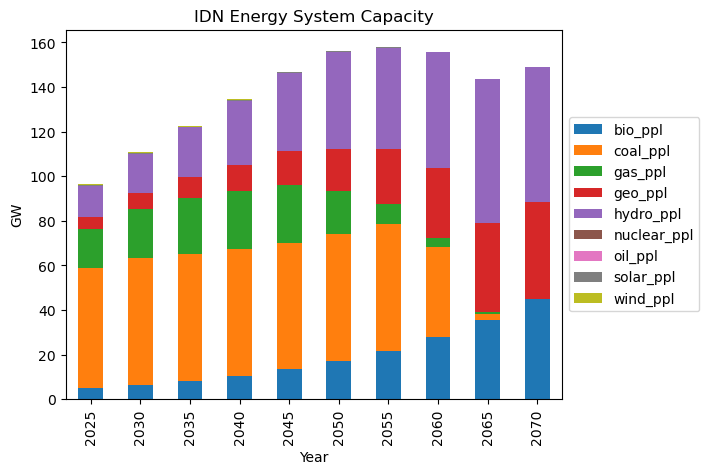

In [ ]:
rep.get('plot capacity')

<Axes: title={'center': 'IDN Fossil Supply'}, xlabel='Resource volume [GWa]', ylabel='Cost [USD / KWa]'>

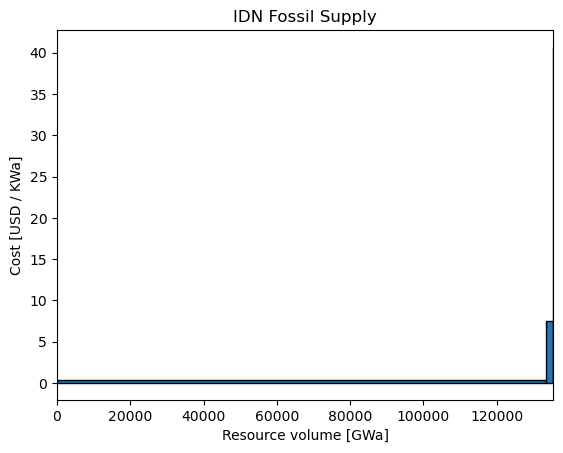

In [183]:
rep.set_filters()
rep.get("plot fossil supply curve")


In [184]:
rep.set_filters()
rep.get("plot extraction")


Insert length-1 dimension for {"y": []}


ComputationError: computing 'plot extraction' using:

(functools.partial(<function stacked_bar at 0x000001964A2FEEE0>, dims=('n', 'c', 'g', 'y'), units='GW', title='Energy System Extraction', cf=1.0, stacked=True), 'EXT:n-c-g-y')

Use Computer.describe(...) to trace the computation.

Computation traceback:
  File "c:\Users\M Ilham Rizaldi\anaconda3\envs\message-env\lib\site-packages\message_ix\report\operator.py", line 198, in stacked_bar
    title=f"{df.loc[0, dims[0]]} {title}",
  File "c:\Users\M Ilham Rizaldi\anaconda3\envs\message-env\lib\site-packages\pandas\core\indexing.py", line 1184, in __getitem__
    return self._getitem_tuple(key)
  File "c:\Users\M Ilham Rizaldi\anaconda3\envs\message-env\lib\site-packages\pandas\core\indexing.py", line 1368, in _getitem_tuple
    return self._getitem_lowerdim(tup)
  File "c:\Users\M Ilham Rizaldi\anaconda3\envs\message-env\lib\site-packages\pandas\core\indexing.py", line 1065, in _getitem_lowerdim
    section = self._getitem_axis(key, axis=i)
  File "c:\Users\M Ilham Rizaldi\anaconda3\envs\message-env\lib\site-packages\pandas\core\indexing.py", line 1431, in _getitem_axis
    return self._get_label(key, axis=axis)
  File "c:\Users\M Ilham Rizaldi\anaconda3\envs\message-env\lib\site-packages\pandas\core\indexing.py", line 1381, in _get_label
    return self.obj.xs(label, axis=axis)
  File "c:\Users\M Ilham Rizaldi\anaconda3\envs\message-env\lib\site-packages\pandas\core\generic.py", line 4301, in xs
    loc = index.get_loc(key)
  File "c:\Users\M Ilham Rizaldi\anaconda3\envs\message-env\lib\site-packages\pandas\core\indexes\range.py", line 415, in get_loc
    raise KeyError(key) from err
KeyError: 0


<Axes: title={'center': 'IDN Energy System Demand'}, xlabel='Year', ylabel='GWa'>

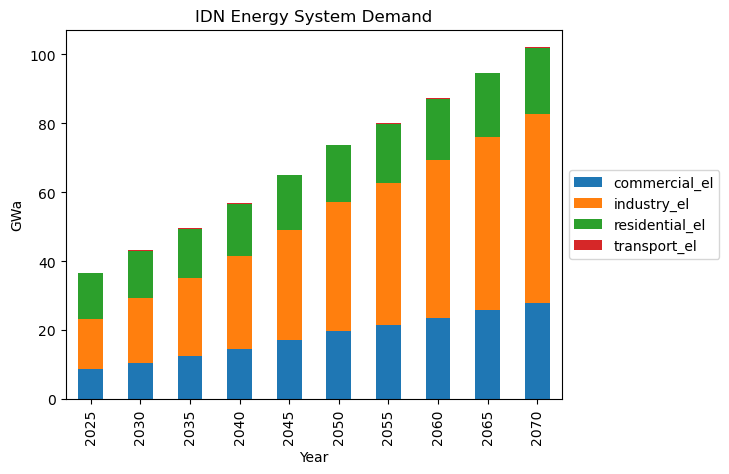

In [185]:
rep.get('plot demand')

In [186]:
scenario.remove_solution()

ValueError: This Scenario does not have a solution!

In [187]:
scenario.check_out()

In [188]:
mp.close_db()